In [1]:
# 导入必要的库

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

import os

import warnings
warnings.filterwarnings('ignore')
os.chdir('ruc_程序设计大作业/code/data')

In [2]:
# 读取数据
dataset = pd.read_csv('./factors/dataset.csv')
print(dataset.shape)
dataset.head()

(2276, 30)


,datetime,r_1Y,r_3m,r_10Y,ndq,diff_r,year,month,day,dayofweek,...,cjbs_und,log_return_und,return_und,hv_1_und,hv_5_und,hv_22_und,hv_66_und,impliedVol,skewness,atm_term_structure
0,2015-02-09,3.0856,3.1228,3.4236,4726.01,0.3380,2015,2,9,0,...,0,0.017309,0.017460,0.000300,0.000305,0.000886,0.000785,0.355165,0.042121,-0.006599
1,2015-02-10,3.0932,3.1516,3.4299,4787.65,0.3367,2015,2,10,1,...,0,0.016171,0.016302,0.000261,0.000187,0.000898,0.000789,0.338991,0.007435,-0.004143
2,2015-02-11,3.0928,3.1516,3.3955,4801.18,0.3027,2015,2,11,2,...,0,0.004633,0.004643,0.000021,0.000152,0.000894,0.000789,0.289229,-0.137441,0.000569
3,2015-02-12,3.0872,3.1388,3.3865,4857.61,0.2993,2015,2,12,3,...,0,0.001679,0.001681,0.000003,0.000141,0.000893,0.000777,0.270184,-0.089587,0.004438
4,2015-02-13,3.0859,3.1088,3.3552,4893.84,0.2693,2015,2,13,4,...,0,0.002514,0.002517,0.000006,0.000118,0.000893,0.000775,0.235578,-0.135373,0.003718


In [3]:
# 构造label
dataset['label_impliedVol'] = dataset['impliedVol'].shift(-1)
dataset['label_skewness'] = dataset['skewness'].shift(-1)
dataset['label_atm_term_structure'] = dataset['atm_term_structure'].shift(-1)

label_cols = ['label_impliedVol', 'label_skewness', 'label_atm_term_structure']

# AR特征
windows = [1, 5, 22, 66]
AR_cols = ['impliedVol', 'skewness', 'atm_term_structure']
for col in AR_cols:
    for window in windows:
        dataset[col + '_AR_' + str(window)] = dataset[col].shift(window) # 知识点：shift函数用于平移数据

dataset.dropna(inplace=True)
dataset.reset_index(drop=True, inplace=True)
print(dataset.shape)
dataset.head()

(2209, 45)


,datetime,r_1Y,r_3m,r_10Y,ndq,diff_r,year,month,day,dayofweek,...,impliedVol_AR_22,impliedVol_AR_66,skewness_AR_1,skewness_AR_5,skewness_AR_22,skewness_AR_66,atm_term_structure_AR_1,atm_term_structure_AR_5,atm_term_structure_AR_22,atm_term_structure_AR_66
0,2015-05-21,2.4373,2.0998,3.4257,5090.79,0.9884,2015,5,21,3,...,0.255156,0.355165,-0.396733,-0.249197,-0.553418,0.042121,0.008412,0.008353,0.035478,-0.006599
1,2015-05-22,2.3822,2.0622,3.4160,5089.36,1.0338,2015,5,22,4,...,0.305656,0.338991,0.167267,-0.510518,-0.160117,0.007435,0.015989,0.032447,0.031528,-0.004143
2,2015-05-25,2.2462,2.1122,3.4310,5089.36,1.1848,2015,5,25,0,...,0.268395,0.289229,-0.131636,-0.258749,-0.105632,-0.137441,0.014883,0.035480,0.047535,0.000569
3,2015-05-26,2.0338,1.9901,3.5214,5032.75,1.4876,2015,5,26,1,...,0.453789,0.270184,-0.517896,0.160464,0.074391,-0.089587,0.033640,0.011505,-0.017646,0.004438
4,2015-05-27,1.8707,1.9167,3.5055,5106.59,1.6348,2015,5,27,2,...,0.459587,0.235578,-0.826912,-0.396733,-0.074222,-0.135373,0.048851,0.008412,-0.027843,0.003718


In [4]:
def cal_eval(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2)) # 知识点：np.sqrt函数用于计算数组中元素的平方根
    mae = np.mean(np.abs(y_true - y_pred)) # 知识点：np.abs函数用于计算数组中元素的绝对值
    mape = np.mean(np.abs(y_true - y_pred) / y_true) # 知识点：np.mean函数用于计算数组中元素的平均值
    r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

    # 涨跌准确率 
    y_true_diff = np.diff(y_true) # 知识点：np.diff函数用于计算数组中相邻元素的差值
    y_pred_diff = np.diff(y_pred)
    recall = np.sum(np.sign(y_true_diff) == np.sign(y_pred_diff)) / len(y_true_diff)
    precision = np.sum(np.sign(y_true_diff) == np.sign(y_pred_diff)) / len(y_pred_diff)

    return rmse, mae, mape, r2, recall, precision

def model_eval(y_true, y_pred):
    iv_true = y_true[:, 0] # 知识点：对数组进行切片
    iv_pred = y_pred[:, 0]

    skewness_true = y_true[:, 1]
    skewness_pred = y_pred[:, 1]

    atm_true = y_true[:, 2]
    atm_pred = y_pred[:, 2]

    iv_rmse, iv_mae, iv_mape, iv_r2, iv_recall, iv_precision = cal_eval(iv_true, iv_pred)
    skewness_rmse, skewness_mae, skewness_mape, skewness_r2, skewness_recall, skewness_precision = cal_eval(skewness_true, skewness_pred)
    atm_rmse, atm_mae, atm_mape, atm_r2, atm_recall, atm_precision = cal_eval(atm_true, atm_pred)

    return pd.DataFrame({
        'impliedVol': [iv_rmse, iv_mae, iv_mape, iv_r2, iv_recall, iv_precision],
        'skewness': [skewness_rmse, skewness_mae, skewness_mape, skewness_r2, skewness_recall, skewness_precision],
        'atm_term_structure': [atm_rmse, atm_mae, atm_mape, atm_r2, atm_recall, atm_precision]
    }, index=['RMSE', 'MAE', 'MAPE', 'R2', 'Recall', 'Precision'])

## 线性模型

In [5]:
# 数据集划分：90%训练集，10%测试集
train_size = int(len(dataset) * 0.9)
train, test = dataset.iloc[:train_size], dataset.iloc[train_size:] # 知识点：iloc函数用于按行索引选取数据

x_cols = dataset.drop(label_cols+['datetime'], axis=1).columns

x_train, y_train, x_test, y_test = train[x_cols], train[label_cols], test[x_cols], test[label_cols]
print(f'x_train: {x_train.shape}, y_train: {y_train.shape}, x_test: {x_test.shape}, y_test: {y_test.shape}')

x_train: (1988, 41), y_train: (1988, 3), x_test: (221, 41), y_test: (221, 3)


In [6]:
# 逐列标准化
for col in x_cols:
    scaler = StandardScaler() # 知识点：StandardScaler函数用于标准化数据
    x_train[col] = scaler.fit_transform(x_train[col].values.reshape(-1, 1))
    x_test[col] = scaler.transform(x_test[col].values.reshape(-1, 1))
    
for col in label_cols:
    scaler = StandardScaler()
    y_train[col] = scaler.fit_transform(y_train[col].values.reshape(-1, 1))
    y_test[col] = scaler.transform(y_test[col].values.reshape(-1, 1))

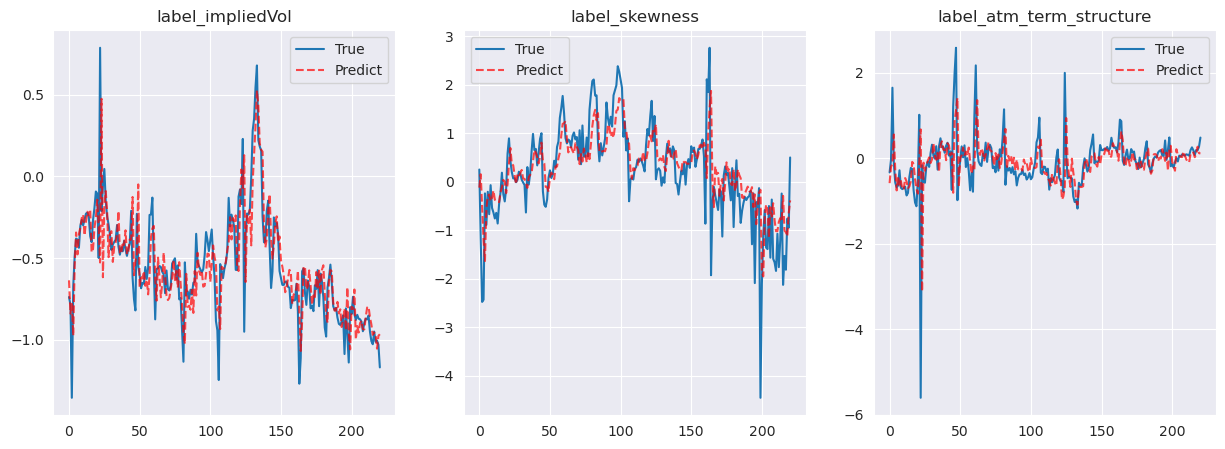

In [7]:
# 多元线性回归
model = LinearRegression() # 知识点：LinearRegression函数用于线性回归
model.fit(x_train, y_train)
y_pred_linearcomb = model.predict(x_test)

# 评估模型，三个序列分别画出
plt.figure(figsize=(15, 5))
for i, col in enumerate(label_cols):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test[col].reset_index(drop=True), label='True')
    plt.plot(y_pred_linearcomb[:, i], label='Predict', alpha = 0.7, linestyle='--', color='red')
    plt.title(col)
    plt.legend()
    plt.grid()
plt.show()

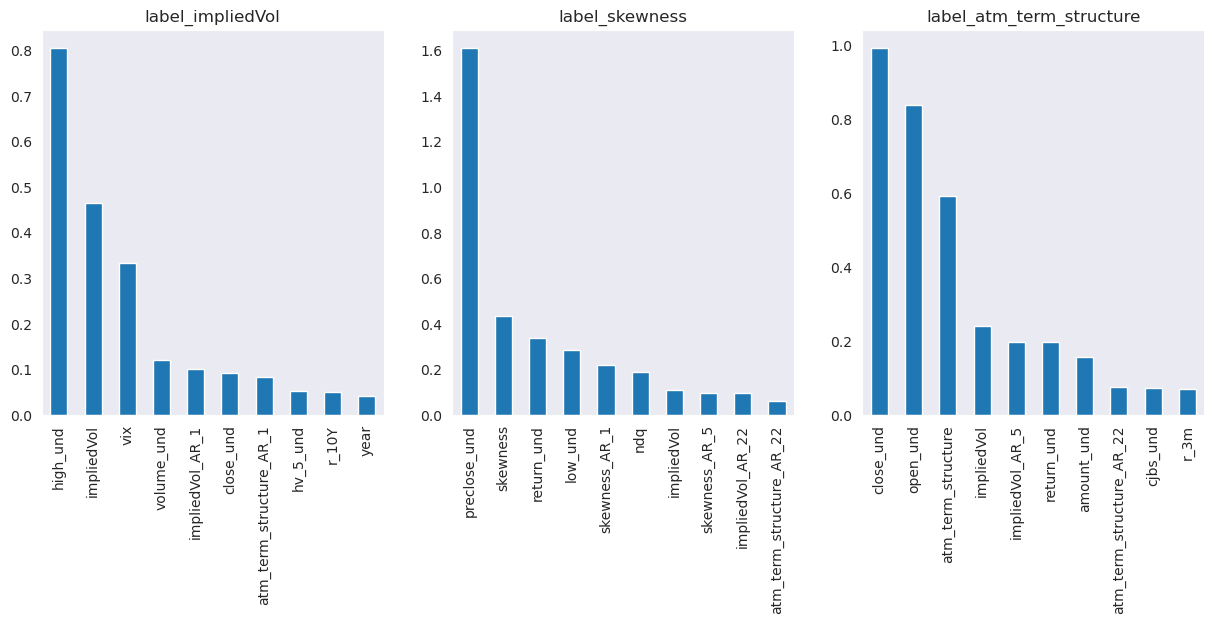

In [8]:
# 系数作为特征重要度
importance_df = pd.DataFrame(model.coef_, columns=x_cols, index=label_cols) 

plt.figure(figsize=(15, 5))
for i, col in enumerate(label_cols):
    plt.subplot(1, 3, i+1)
    importance = importance_df.loc[col].sort_values(ascending=False)
    importance[:10].plot(kind='bar')
    plt.title(col)
plt.show()

In [9]:
eval_linear = model_eval(y_test.values, y_pred_linearcomb)
eval_linear 

,impliedVol,skewness,atm_term_structure
RMSE,0.212334,0.677570,0.664561
MAE,0.138552,0.438854,0.335039
MAPE,1.492009,0.720347,-0.514461
R2,0.579792,0.527095,-0.078914
Recall,0.504545,0.386364,0.431818
Precision,0.504545,0.386364,0.431818


## PCA+线性模型

In [10]:
# PCA
pca = PCA(n_components=0.80)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
print(f'x_train_pca: {x_train_pca.shape}, x_test_pca: {x_test_pca.shape}')

x_train_pca: (1988, 12), x_test_pca: (221, 12)


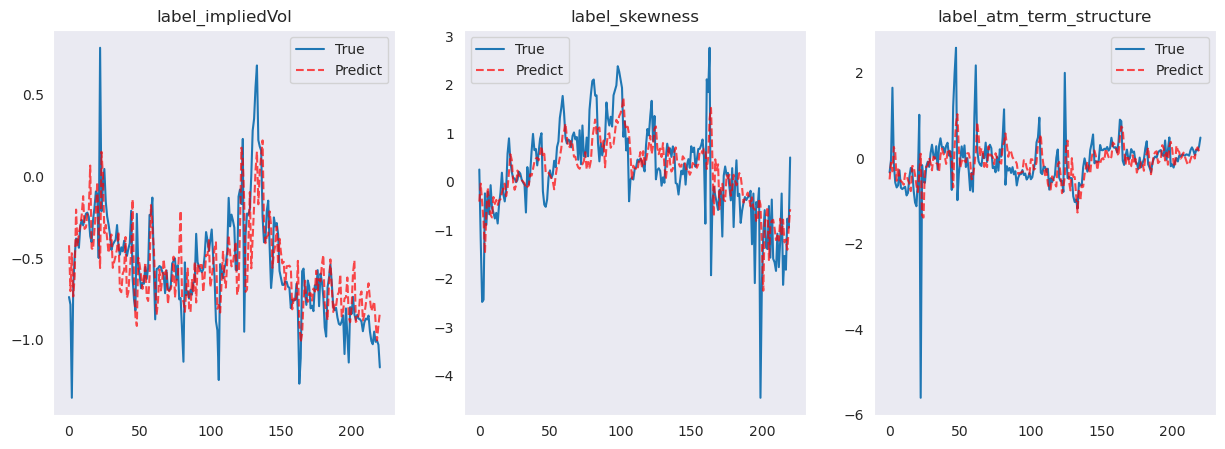

In [11]:
# 多元线性回归
model = LinearRegression()
model.fit(x_train_pca, y_train)
y_pred_linear_pca = model.predict(x_test_pca)

# 评估模型，三个序列分别画出
plt.figure(figsize=(15, 5))
for i, col in enumerate(label_cols):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test[col].reset_index(drop=True), label='True')
    plt.plot(y_pred_linear_pca[:, i], label='Predict', alpha = 0.7, linestyle='--', color='red')
    plt.title(col)
    plt.legend()
plt.show()

In [12]:
eval_linear_pca = model_eval(y_test.values, y_pred_linear_pca)
eval_linear_pca

,impliedVol,skewness,atm_term_structure
RMSE,0.244142,0.700785,0.629271
MAE,0.174814,0.491764,0.350529
MAPE,2.065110,1.059887,2.321636
R2,0.444469,0.494134,0.032630
Recall,0.481818,0.413636,0.472727
Precision,0.481818,0.413636,0.472727


## 分类降维+线性模型

In [13]:
time_cols = ['year', 'month', 'day', 'dayofweek']
general_cols = ['r_1Y', 'r_3m', 'r_10Y', 'ndq', 'diff_r']
option_cols = ['vix', 'PCR_cur', 'PCR_next', 'skewness',
       'atm_term_structure']
und_cols = [ 'close', 'open', 'high', 'low', 'preclose', 'volume', 'amount', 'cjbs', 'log_return', 'return', 'hv_1', 'hv_5', 'hv_22', 'hv_66']
und_cols = [i + '_und' for i in und_cols]

AR_cols = ['impliedVol_AR_1', 'impliedVol_AR_5',
       'impliedVol_AR_22', 'impliedVol_AR_66', 'skewness_AR_1',
       'skewness_AR_5', 'skewness_AR_22', 'skewness_AR_66',
       'atm_term_structure_AR_1', 'atm_term_structure_AR_5',
       'atm_term_structure_AR_22', 'atm_term_structure_AR_66']

label_cols = ['label_impliedVol', 'label_skewness', 'label_atm_term_structure']

In [14]:
# 分类降维
def linear_comb(cols, label_cols, x_train, y_train, x_test):
    model = LinearRegression()
    model.fit(x_train[cols], y_train[label_cols])
    x = pd.concat([x_train[cols], x_test[cols]])
    factor = model.predict(x)
    return factor

time_factors = linear_comb(time_cols, label_cols, x_train, y_train, x_test)
general_factors = linear_comb(general_cols, label_cols, x_train, y_train, x_test)
option_factors = linear_comb(option_cols, label_cols, x_train, y_train, x_test)
und_factors = linear_comb(und_cols, label_cols, x_train, y_train, x_test)

# drop掉合成后的特征
x_train.drop(time_cols+general_cols+option_cols+und_cols, axis=1, inplace=True)
x_test.drop(time_cols+general_cols+option_cols+und_cols, axis=1, inplace=True)
x = pd.concat([x_train, x_test])

# 添加合成后的特征，每个有3列
for i in range(3):
    x['time_factor_'+str(i)] = time_factors[:, i]
    x['general_factor_'+str(i)] = general_factors[:, i]
    x['option_factor_'+str(i)] = option_factors[:, i]
    x['und_factor_'+str(i)] = und_factors[:, i]

x_train = x.iloc[:len(x_train)]
x_test = x.iloc[len(x_train):]

x_train.shape, x_test.shape

((1988, 25), (221, 25))

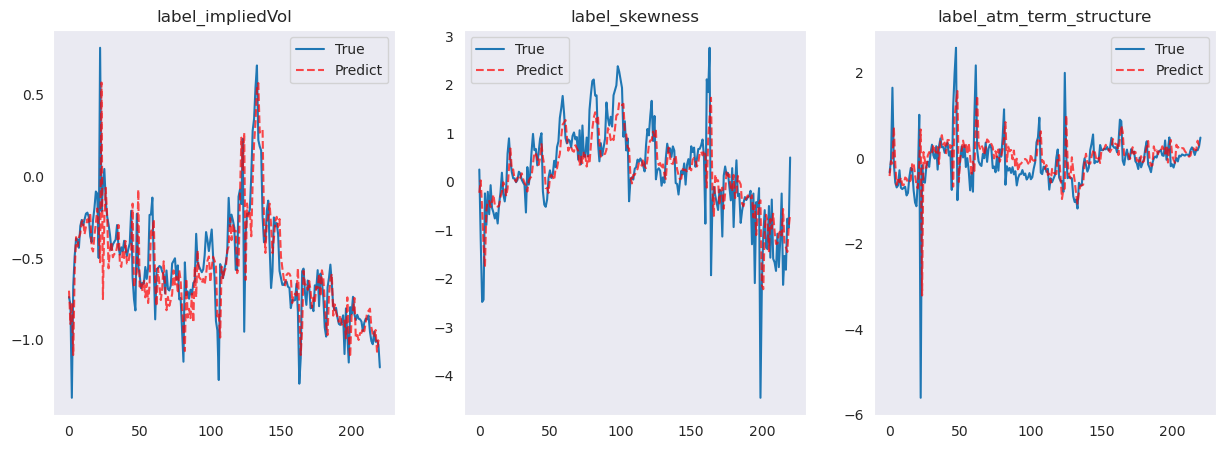

In [15]:
# 多元线性回归
model = LinearRegression()
model.fit(x_train, y_train)
y_pred_linear_comb = model.predict(x_test)

# 评估模型，三个序列分别画出
plt.figure(figsize=(15, 5))
for i, col in enumerate(label_cols):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test[col].reset_index(drop=True), label='True')
    plt.plot(y_pred_linear_comb[:, i], label='Predict', alpha = 0.7, linestyle='--', color='red')
    plt.title(col)
    plt.legend()
plt.show()

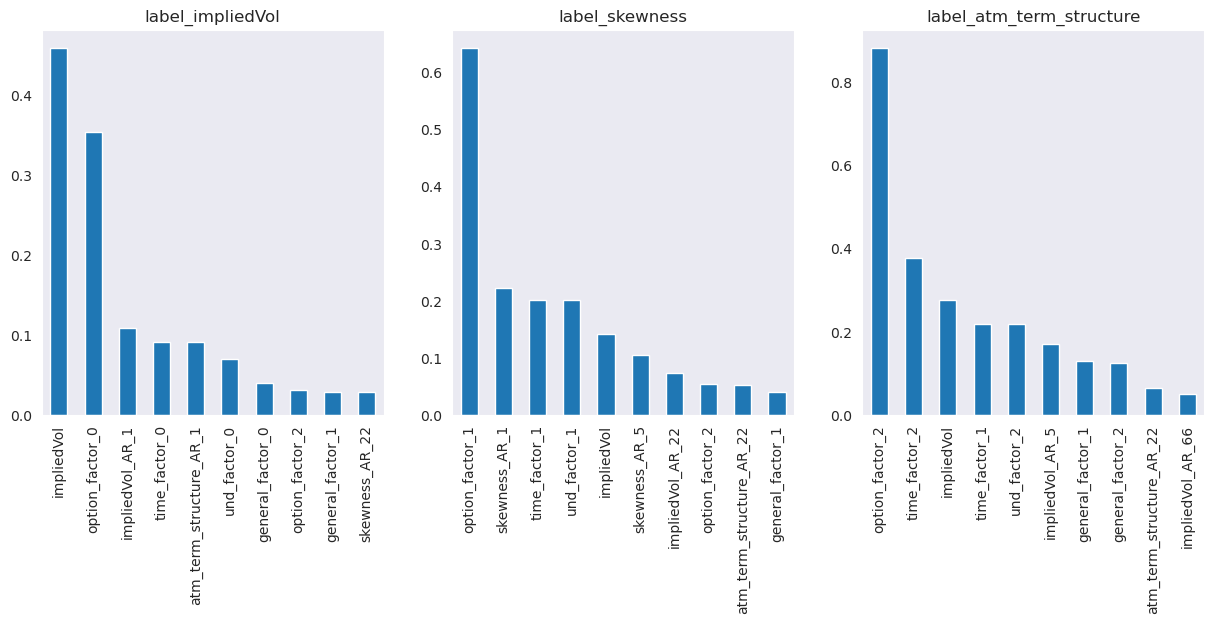

In [16]:
# 系数作为特征重要度
importance_df = pd.DataFrame(model.coef_, columns=x_train.columns, index=label_cols)

plt.figure(figsize=(15, 5))
for i, col in enumerate(label_cols):
    plt.subplot(1, 3, i+1)
    importance = importance_df.loc[col].sort_values(ascending=False)
    importance[:10].plot(kind='bar')
    plt.title(col)
plt.show()

In [17]:
# 评估模型
eval_linear_comb = model_eval(y_test.values, y_pred_linear_comb)
eval_linear_comb

,impliedVol,skewness,atm_term_structure
RMSE,0.224937,0.661670,0.677951
MAE,0.146796,0.437142,0.349082
MAPE,1.236259,0.040271,-0.445901
R2,0.528429,0.549030,-0.122827
Recall,0.468182,0.409091,0.440909
Precision,0.468182,0.409091,0.440909


## 非线性模型-lgbm

In [18]:
# 数据集划分：70%训练集，20%验证集，10%测试集
train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset) * 0.2)
train, val, test = dataset.iloc[:train_size], dataset.iloc[train_size:train_size+val_size], dataset.iloc[train_size+val_size:]

x_train, y_train, x_val, y_val, x_test, y_test = train[x_cols], train[label_cols], val[x_cols], val[label_cols], test[x_cols], test[label_cols]
print(f'x_train: {x_train.shape}, y_train: {y_train.shape}, x_val: {x_val.shape}, y_val: {y_val.shape}, x_test: {x_test.shape}, y_test: {y_test.shape}')

x_train: (1546, 41), y_train: (1546, 3), x_val: (441, 41), y_val: (441, 3), x_test: (222, 41), y_test: (222, 3)


In [19]:
# 逐列标准化
for col in x_cols:
    scaler = StandardScaler()
    x_train[col] = scaler.fit_transform(x_train[col].values.reshape(-1, 1))
    x_val[col] = scaler.transform(x_val[col].values.reshape(-1, 1))
    x_test[col] = scaler.transform(x_test[col].values.reshape(-1, 1))

for col in label_cols:
    scaler = StandardScaler()
    y_train[col] = scaler.fit_transform(y_train[col].values.reshape(-1, 1))
    y_val[col] = scaler.transform(y_val[col].values.reshape(-1, 1))
    y_test[col] = scaler.transform(y_test[col].values.reshape(-1, 1))

In [20]:
# lightgbm

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
}

model_1 = lgb.LGBMRegressor(**params) # 知识点：lgm.LGBMRegressor函数用于lightgbm回归
model_2 = lgb.LGBMRegressor(**params) # 知识点：**params用于传递参数，其中**表示将字典解包
model_3 = lgb.LGBMRegressor(**params)

model_1.fit(x_train, y_train['label_impliedVol'], eval_set=[(x_val, y_val['label_impliedVol'])])
model_2.fit(x_train, y_train['label_skewness'], eval_set=[(x_val, y_val['label_skewness'])])
model_3.fit(x_train, y_train['label_atm_term_structure'], eval_set=[(x_val, y_val['label_atm_term_structure'])])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9494
[LightGBM] [Info] Number of data points in the train set: 1546, number of used features: 41
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9494
[LightGBM] [Info] Number of data points in the train set: 1546, number of used features: 41
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9494
[LightGBM] [Info] Number of data points in the train set: 1546, number of used features: 41
[LightGBM] [Info] Start trai

LGBMRegressor(learning_rate=0.05, metric='rmse', objective='regression')

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

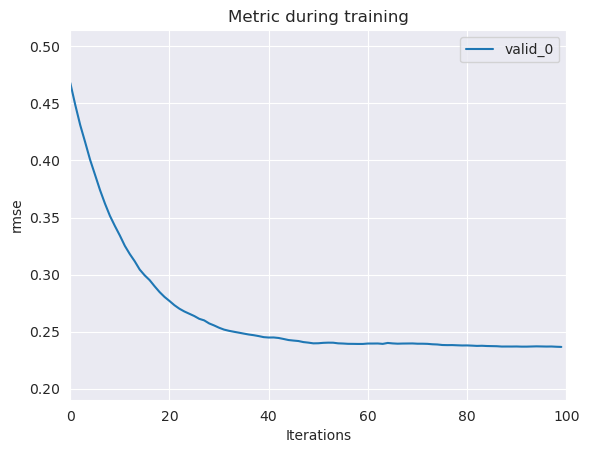

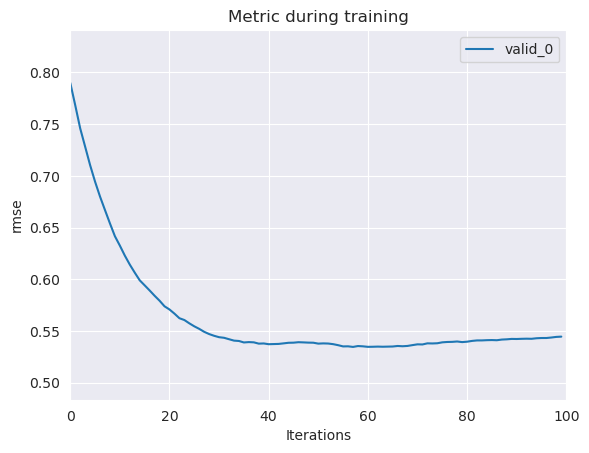

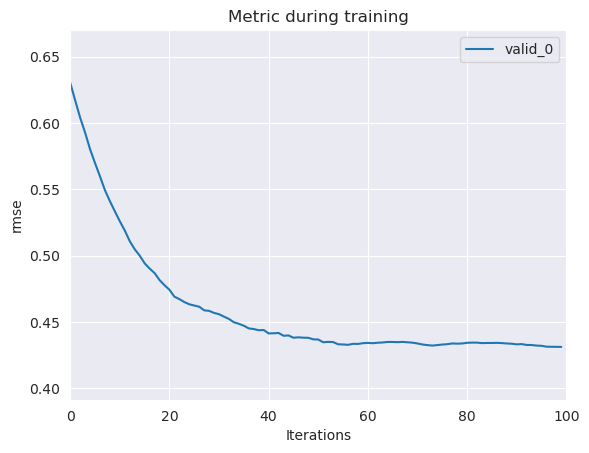

In [21]:
# 打印训练过程
lgb.plot_metric(model_1) # 知识点：lgb.plot_metric函数用于绘制模型的评估指标
lgb.plot_metric(model_2)
lgb.plot_metric(model_3)

<AxesSubplot:>

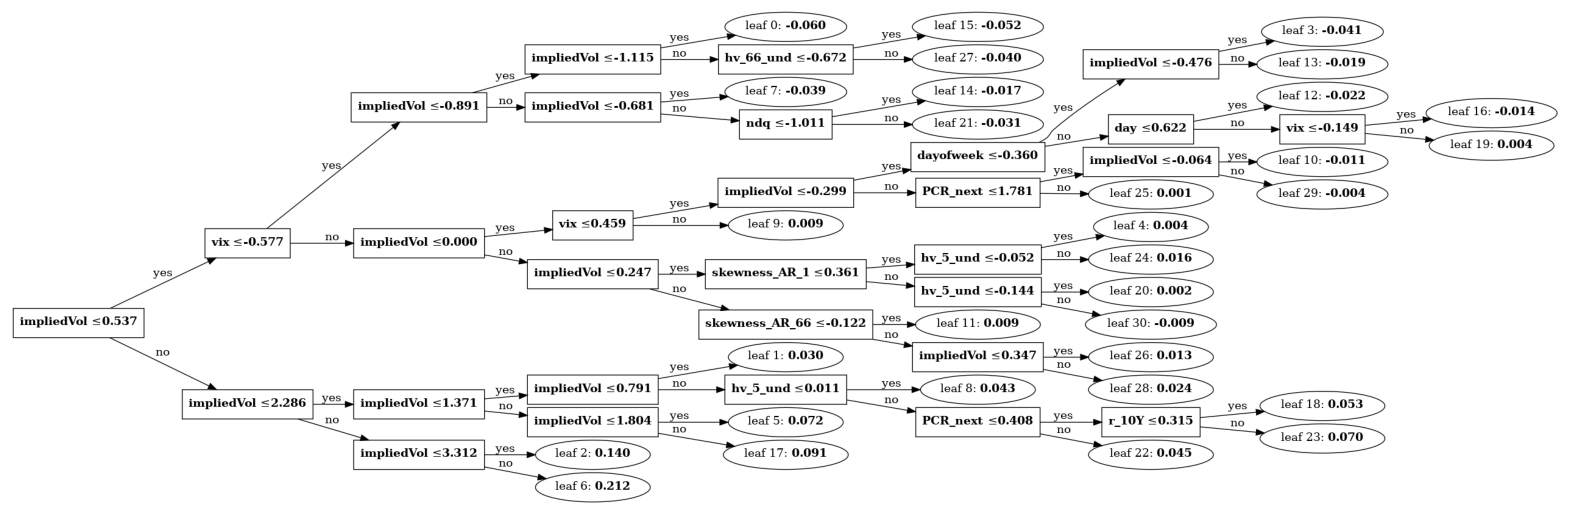

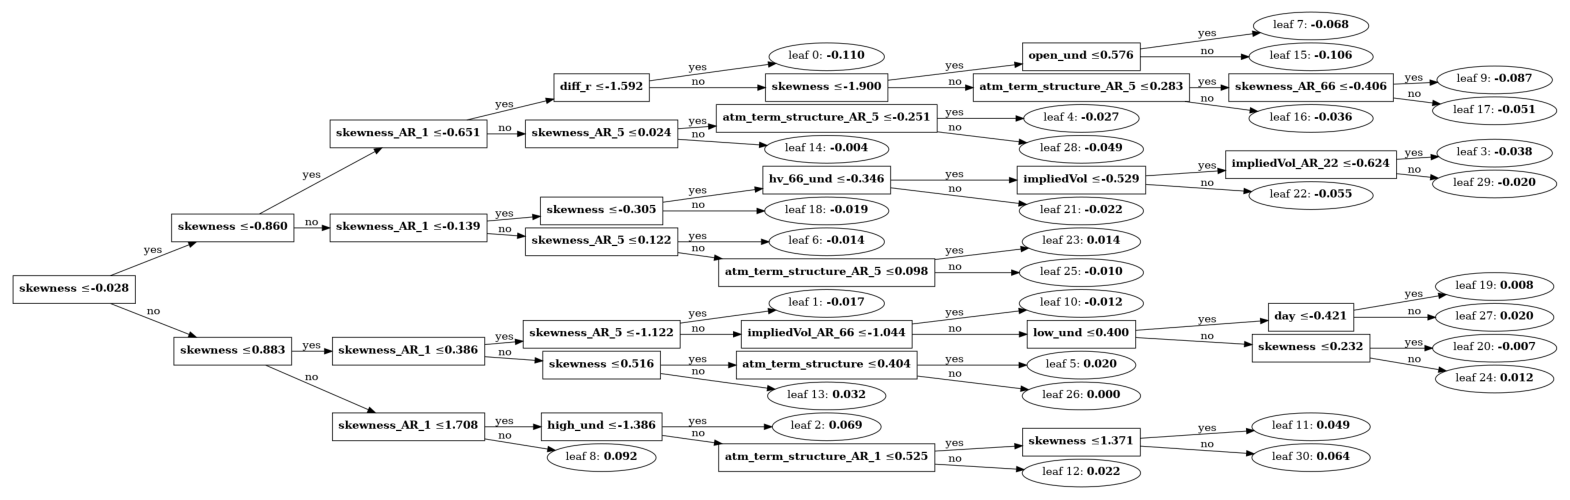

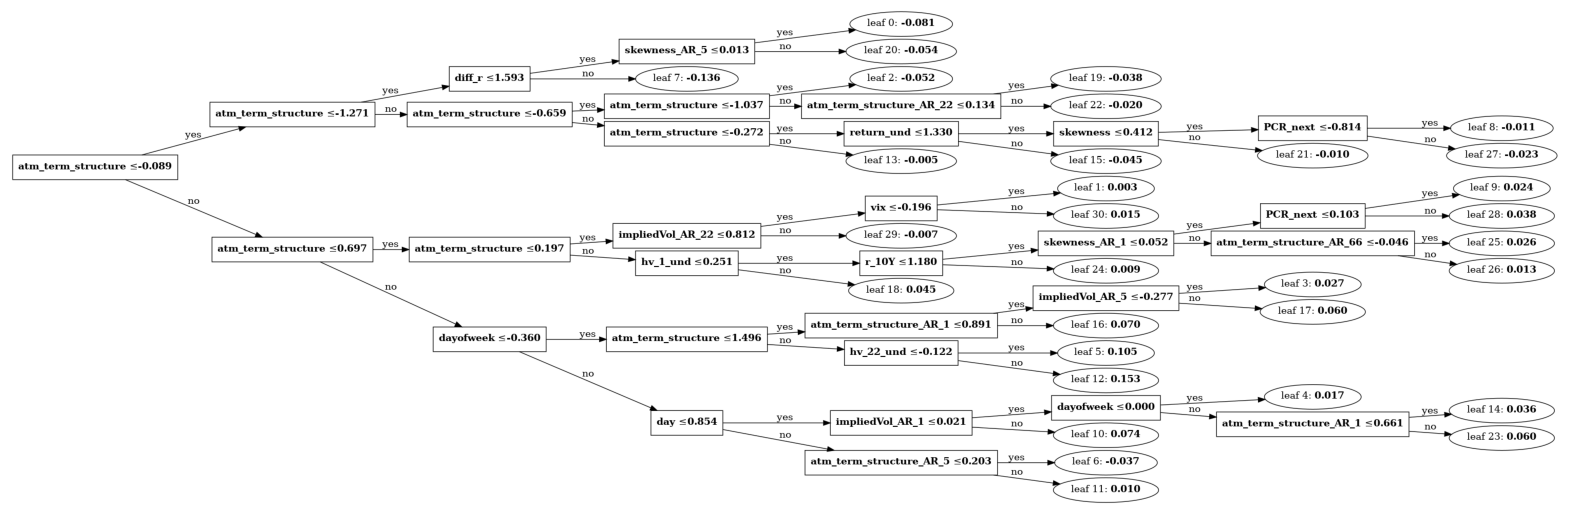

In [22]:
lgb.plot_tree(model_1, figsize=(20, 20)) # 知识点：lgb.plot_tree函数用于绘制树
lgb.plot_tree(model_2, figsize=(20, 20))
lgb.plot_tree(model_3, figsize=(20, 20))

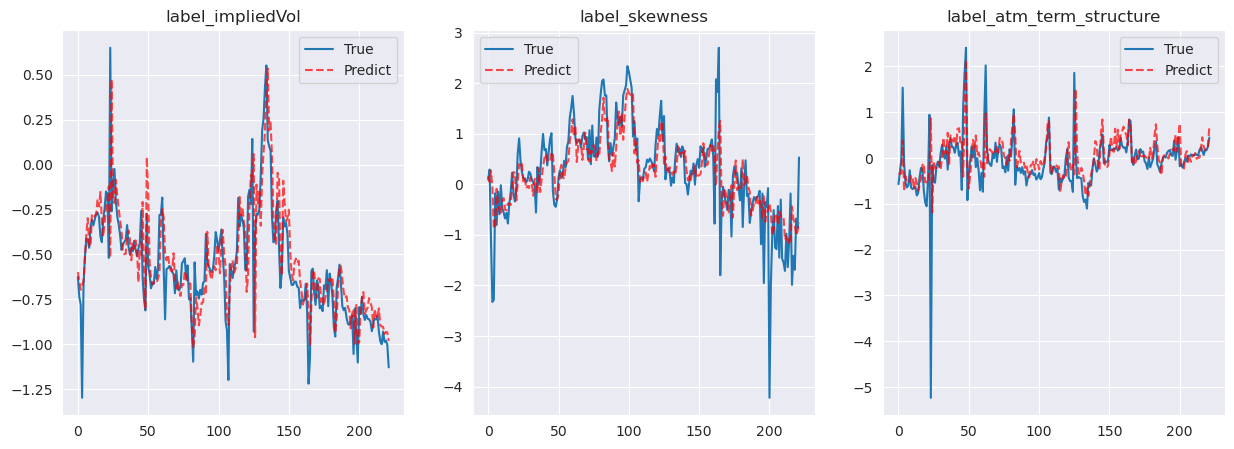

In [28]:
# 预测
y_pred_impliedVol = model_1.predict(x_test)
y_pred_skewness = model_2.predict(x_test)
y_pred_atm_term_structure = model_3.predict(x_test)

y_pred_lgb = np.vstack([y_pred_impliedVol, y_pred_skewness, y_pred_atm_term_structure]).T # 知识点：np.vstack函数用于沿着垂直方向堆叠数组，同时.T表示转置

# 评估模型，三个序列分别画出
plt.figure(figsize=(15, 5))
for i, col in enumerate(label_cols):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test[col].reset_index(drop=True), label='True')
    plt.plot(y_pred_lgb[:, i], label='Predict',  alpha = 0.7, linestyle='--', color='red')
    plt.title(col)
    plt.legend()
    plt.grid()
plt.show()

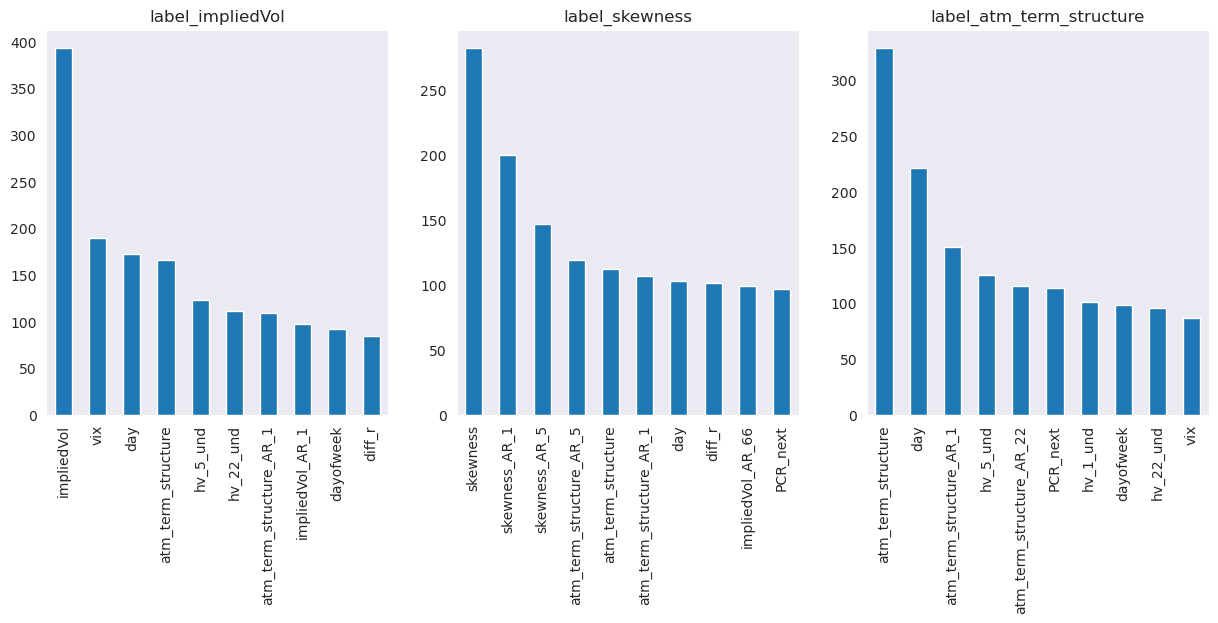

In [24]:
# 特征重要度
importance_df = pd.DataFrame({'label_impliedVol': model_1.feature_importances_, 'label_skewness': model_2.feature_importances_, 'label_atm_term_structure': model_3.feature_importances_}, index=x_cols)

plt.figure(figsize=(15, 5))
for i, col in enumerate(label_cols):
    plt.subplot(1, 3, i+1)
    importance = importance_df[col].sort_values(ascending=False)
    importance[:10].plot(kind='bar')
    plt.title(col)
plt.show()

In [25]:
eval_lgb = model_eval(y_test.values, y_pred_lgb)
eval_lgb

,impliedVol,skewness,atm_term_structure
RMSE,0.192677,0.630999,0.577035
MAE,0.126010,0.416651,0.301511
MAPE,-0.236257,-0.733386,0.178240
R2,0.579420,0.553061,0.063599
Recall,0.579186,0.457014,0.447964
Precision,0.579186,0.457014,0.447964


## 对比

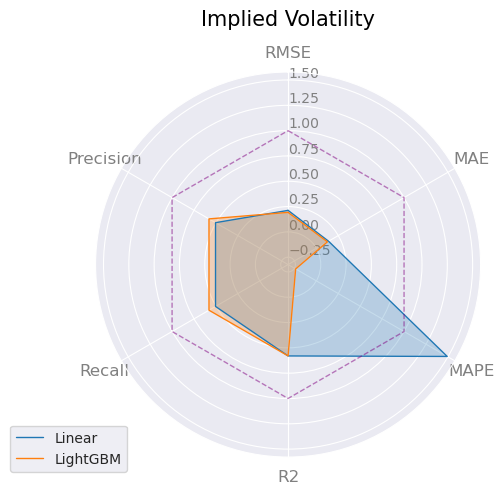

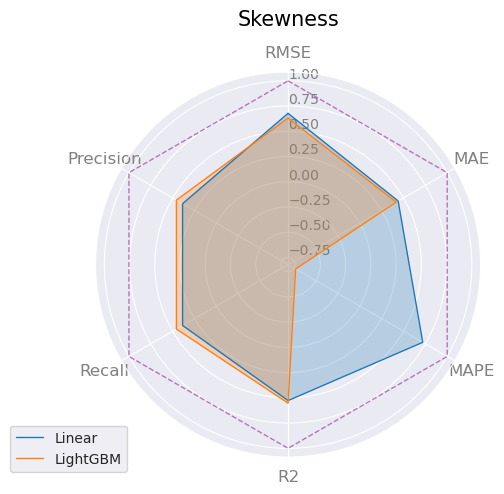

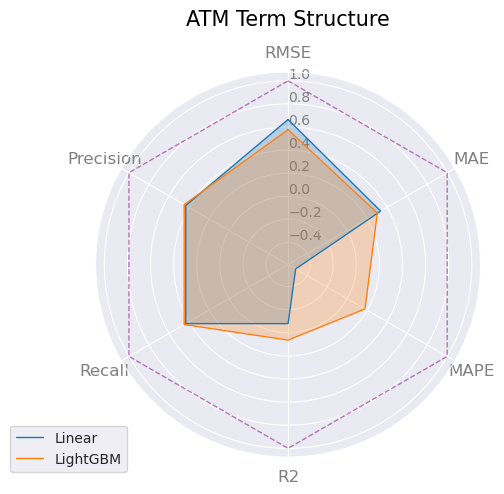

In [26]:
def create_hexagon_radar_chart(data, labels, models, title): # 绘制六边形雷达图
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() # 知识点：np.linspace函数用于生成等差数列

    angles += angles[:1] # 滚动相加的简洁写法

    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    
    plt.xticks(angles[:-1], labels, color='grey', size=12)
    ax.tick_params(colors='grey')

    for i, model in enumerate(models):
        values = data.iloc[i, 1:].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.25)
    outer_values = [1] * num_vars
    outer_values += outer_values[:1]
    ax.plot(angles, outer_values, linewidth=1, linestyle = 'dashed', color='purple', alpha = 0.5)

    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.title(title, size=15, color='black', y=1.1)
    plt.show()

models = ['Linear', 'LightGBM']
iv_df = pd.concat([eval_linear.iloc[:,0], eval_lgb.iloc[:,0]], axis=1).T.reset_index(drop=True)
iv_df['models'] = models
iv_df = iv_df[iv_df.columns[-1:].tolist() + iv_df.columns[:-1].tolist()] # 知识点：巧用列表索引移动列的位置

skew_df = pd.concat([eval_linear.iloc[:,1], eval_lgb.iloc[:,1]], axis=1).T  
skew_df['models'] = models
skew_df = skew_df[skew_df.columns[-1:].tolist() + skew_df.columns[:-1].tolist()]

atm_df = pd.concat([eval_linear.iloc[:,2], eval_lgb.iloc[:,2]], axis=1).T
atm_df['models'] = models
atm_df = atm_df[atm_df.columns[-1:].tolist() + atm_df.columns[:-1].tolist()]

create_hexagon_radar_chart(iv_df, ['RMSE', 'MAE', 'MAPE', 'R2', 'Recall', 'Precision'], models, 'Implied Volatility')
create_hexagon_radar_chart(skew_df, ['RMSE', 'MAE', 'MAPE', 'R2', 'Recall', 'Precision'], models, 'Skewness')
create_hexagon_radar_chart(atm_df, ['RMSE', 'MAE', 'MAPE', 'R2', 'Recall', 'Precision'], models, 'ATM Term Structure')